# Diabetes Analysis: EDA, Feature Selection, and Classification Models

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, roc_curve, auc)

# Load dataset
df = pd.read_csv('diabetes.csv')
# Display first few rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis


In [4]:
# Summary statistics
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

## Feature Importance (Decision Tree)


                    feature  importance
0                   Glucose    0.315754
1                       BMI    0.238072
2                       Age    0.111681
3  DiabetesPedigreeFunction    0.109847
4             BloodPressure    0.103889
5               Pregnancies    0.057879
6                   Insulin    0.045712
7             SkinThickness    0.017166


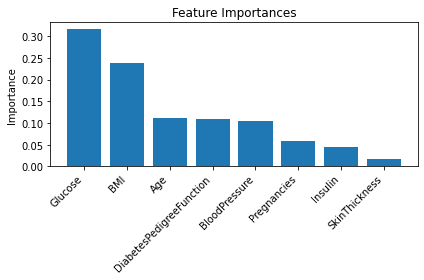

In [5]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train Decision Tree on full data
clf_full = DecisionTreeClassifier(random_state=123)
clf_full.fit(X, y)

# Compute importances
importances = clf_full.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)
print(feat_imp)

# Plot importances
plt.figure()
plt.bar(feat_imp['feature'], feat_imp['importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## Feature Selection


In [6]:
# Select top 5 features
top_features = feat_imp['feature'].head(5).tolist()
print("Top 5 features:", top_features)

# Subset dataset
X_selected = df[top_features]
y = df['Outcome']

Top 5 features: ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure']


## Data Splitting (70% Train, 20% Validation, 10% Test)

In [7]:
# First split: train+val (90%) and test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_selected, y, test_size=0.1, random_state=123, stratify=y)

# Second split: train (70%) and val (20%) of original
val_ratio = 20/90
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio, random_state=123, stratify=y_train_val)

print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 537, Validation: 154, Test: 77


## K-Nearest Neighbors Classification


In [15]:
# Try multiple k values
k_values = [1, 3, 5, 7, 9]
knn_accuracies = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_accuracies[k] = accuracy_score(y_val, knn.predict(X_val))

# Print accuracies
for k, acc in knn_accuracies.items():
    print(f"k={k}: accuracy={acc:.4f}")

# Select best k
best_k = max(knn_accuracies, key=knn_accuracies.get)
print(f"Best k: {best_k}")

k=1: accuracy=0.6753
k=3: accuracy=0.7403
k=5: accuracy=0.7468
k=7: accuracy=0.7662
k=9: accuracy=0.7727
Best k: 9


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.86      0.67      0.75        27

    accuracy                           0.84        77
   macro avg       0.85      0.80      0.82        77
weighted avg       0.85      0.84      0.84        77



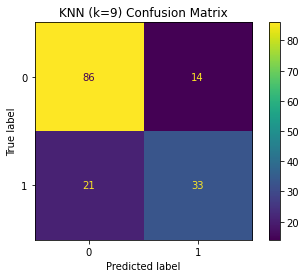

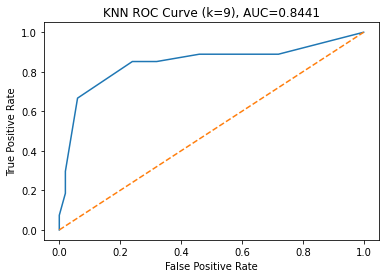

In [16]:
# Evaluate best KNN
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_knn_pred = knn_best.predict(X_test)
y_knn_prob = knn_best.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_knn_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(knn_best, X_val, y_val)
plt.title(f'KNN (k={best_k}) Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_knn_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'KNN ROC Curve (k={best_k}), AUC={roc_auc:.4f}')
plt.show()

## Gaussian Naive Bayes Classification

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       100
           1       0.71      0.65      0.68        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



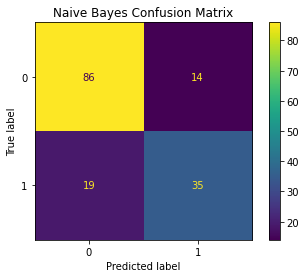

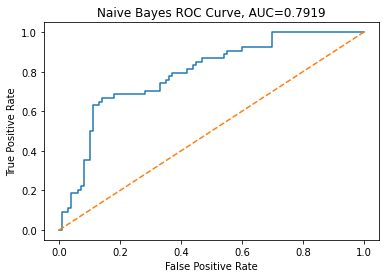

In [10]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_nb_pred = gnb.predict(X_val)
y_nb_prob = gnb.predict_proba(X_val)[:, 1]

# Classification report
print(classification_report(y_val, y_nb_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(gnb, X_val, y_val)
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_nb_prob)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Naive Bayes ROC Curve, AUC={roc_auc_nb:.4f}')
plt.show()

## Decision Tree Classification

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       100
           1       0.54      0.63      0.58        54

    accuracy                           0.68       154
   macro avg       0.66      0.67      0.66       154
weighted avg       0.70      0.68      0.69       154



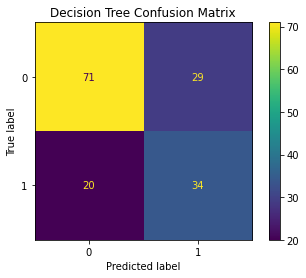

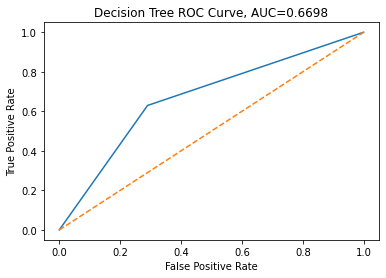

In [11]:
# Train Decision Tree
clf = DecisionTreeClassifier(random_state=123)
clf.fit(X_train, y_train)
y_dt_pred = clf.predict(X_val)
y_dt_prob = clf.predict_proba(X_val)[:, 1]

# Classification report
print(classification_report(y_val, y_dt_prob))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
plt.title('Decision Tree Confusion Matrix')
plt.show()

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_dt_prob)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Decision Tree ROC Curve, AUC={roc_auc_dt:.4f}')
plt.show()

### Visualizing the Decision Tree
Just for fun

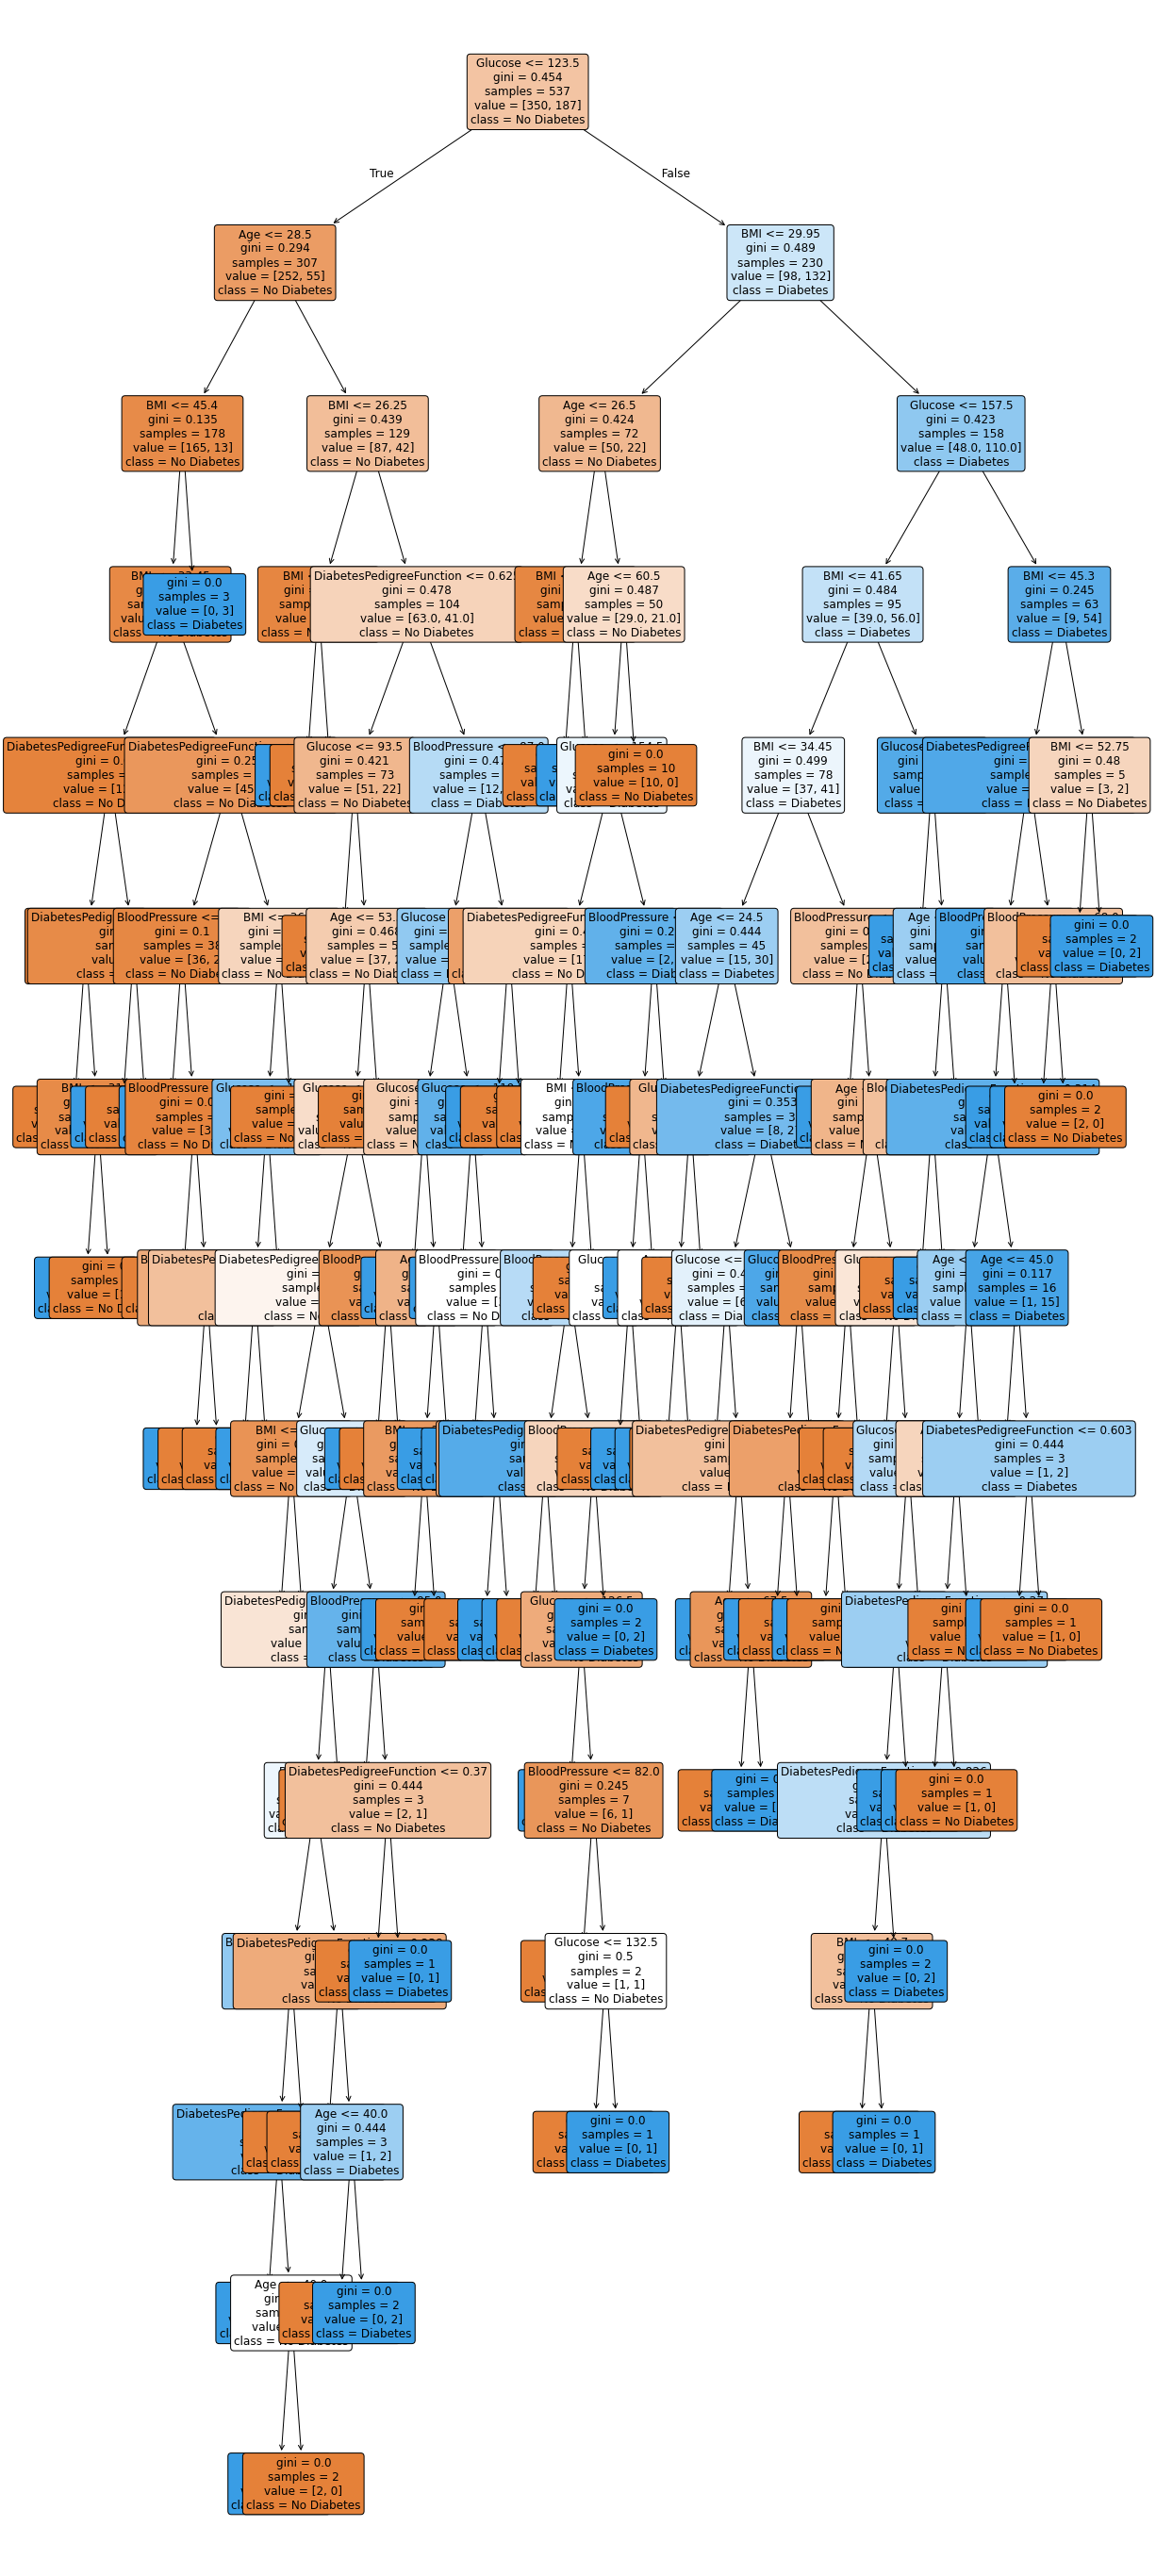

In [12]:
from sklearn.tree import plot_tree

# Plot the tree
plt.figure(figsize=(20, 50))
plot_tree(
    clf,
    feature_names=top_features,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()

## Best Model Selection and Final Evaluation

Model AUCs: {'KNN': 0.844074074074074, 'Naive Bayes': 0.8992592592592592, 'Decision Tree': 0.7248148148148149}
Best model based on AUC: Naive Bayes

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.83      0.70      0.76        27

    accuracy                           0.84        77
   macro avg       0.84      0.81      0.82        77
weighted avg       0.84      0.84      0.84        77



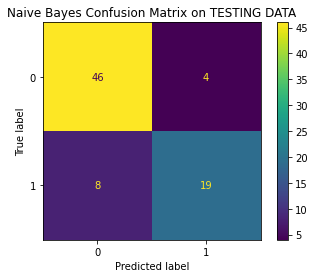

In [13]:
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay

# Compute AUCs for each model
roc_auc_knn = auc(*roc_curve(y_test, knn_best.predict_proba(X_test)[:, 1])[:2])
roc_auc_nb  = auc(*roc_curve(y_test, gnb.predict_proba(X_test)[:, 1])[:2])
roc_auc_dt  = auc(*roc_curve(y_test, clf.predict_proba(X_test)[:, 1])[:2])

aucs = {'KNN': roc_auc_knn, 'Naive Bayes': roc_auc_nb, 'Decision Tree': roc_auc_dt}
print("Model AUCs:", aucs)

# Select best model
best_model_name = max(aucs, key=aucs.get)
print(f"Best model based on AUC: {best_model_name}")

# Map name to model instance
MODEL_MAP = {'KNN': knn_best, 'Naive Bayes': gnb, 'Decision Tree': clf}
best_model = MODEL_MAP[best_model_name]

# Final evaluation on test set
y_best_pred = best_model.predict(X_test)
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, y_best_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f'{best_model_name} Confusion Matrix on TESTING DATA')
plt.show()

### ROC Curve for Best Model on Test Set

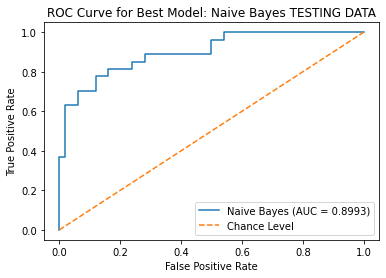

In [14]:
# Compute ROC curve and AUC for the best model
y_best_prob = best_model.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_best_prob)
roc_auc_best = auc(fpr_best, tpr_best)

# Plot ROC curve
plt.figure()
plt.plot(fpr_best, tpr_best, label=f'{best_model_name} (AUC = {roc_auc_best:.4f})')
plt.plot([0, 1], [0, 1], '--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Best Model: {best_model_name} TESTING DATA')
plt.legend(loc='lower right')
plt.show()